In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json
import pandas as pd
import seaborn as sns
from enum import Enum


from bench_utils import parse_intersection_data 


In [2]:
# Geometries
manual_data, _ = parse_intersection_data("manual")
special_cases, _ = parse_intersection_data("latest_export.json", strip_precision=True)
world_data, world_data_stats = parse_intersection_data("world.json", 100, strip_precision=True)
lund_data, lund_data_stats = parse_intersection_data("lund.json", 1000)
sweden_data, sweden_data_stats = parse_intersection_data("sweden-places-a.json")
new_york_data, new_york_data_stats = parse_intersection_data("new-york-natural.json")
waterways_data, waterways_data_stats = parse_intersection_data("nord-est-waterways.json")


In [3]:
SHOW_COORDINATES = True
SHOW_GEOMETRIES = True
SHOW_INTERSECTING_POINTS = True
SHOW_COMMON_BOUNDING_BOX = False
SHOW_BOUNDING_BOXES = False

In [4]:
import intersection.first_bin_search
import intersection.chunk_bbox_intersection
binary_intersection = intersection.first_bin_search.binary_intersection
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting
chunk_bbox_intersection = intersection.chunk_bbox_intersection.intersection

from intersection.plotting import *
import algos.fpd_extended_lib.cfg as cfg
from algos.alg_fpd_extended import FpdExtended

fpd = FpdExtended()

In [5]:
def set_max_num_delta(val):
        cfg.MAX_NUM_DELTAS = val
        cfg.D_CNT_SIZE = cfg.required_bits(val)

Above FAILED!
Expected shape: MULTILINESTRING ((33.7779171 34.9846874, 33.7739897 34.9886665), (33.7739897 34.9886665, 33.7661349 34.9902685), (33.7661349 34.9902685, 33.761484 34.9902685), (33.761484 34.9902685, 33.7592102 34.9886665), (33.7592102 34.9886665, 33.7654114 34.9855659), (33.7654114 34.9855659, 33.7693388 34.9839639), (33.7693388 34.9839639, 33.7708891 34.9800882), (33.7708891 34.9800882, 33.77554 34.9800882), (33.77554 34.9800882, 33.7801909 34.9793131), (33.7801909 34.9793131, 33.7809351 34.9763451), (33.701508 34.9728865, 33.7029346 34.987943), (33.7029346 34.987943, 33.7114612 34.9855659), (33.7114612 34.9855659, 33.7154403 34.9972964), (33.7154403 34.9972964, 33.6997307 35.0027225), (33.6997307 35.0027225, 33.6966301 35.0089753), (33.6966301 35.0089753, 33.7053117 35.0152282), (33.7053117 35.0152282, 33.7022111 35.0222562), (33.7022111 35.0222562, 33.6850029 35.0292842), (33.6850029 35.0292842, 33.6794346 35.0338988), (33.8293868 35.0011722, 33.8403422 34.993369), (33

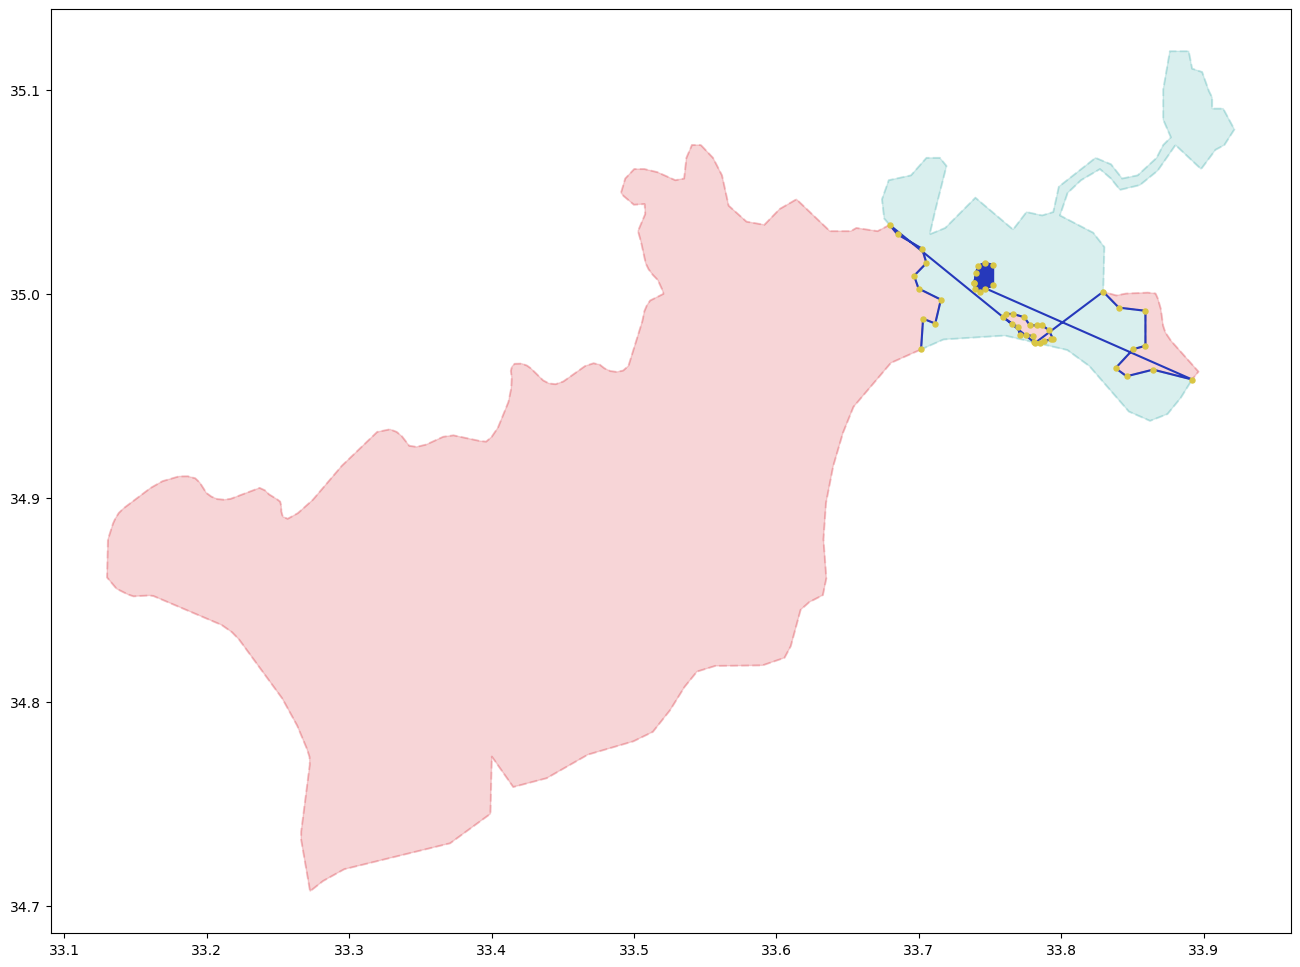

Passed 99 of 100. Total in set: 100
Done. Passed: 99 of 100.


In [6]:
total = 0
passed = 0

def evaluate_dataset(data, plot, total, passed, delta_size=None):
    for i, d in enumerate(data):
        # if i != 12:
        #     continue
        g1, g2 = d
        # if delta_size != None:
        #     set_max_num_delta(delta_size)
        #is_intersecting, intersect_points = binary_intersection(g1, g2)
        _, b1 = fpd.compress(g1)
        _, b2 = fpd.compress(g2)
        exp_boolean = shapely.intersects(g1, g2)
        #is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp_boolean, True)
        stats_is_intersection, is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp_boolean, True, get_stats=True)
        exp_shape = shapely.intersection(g1, g2)
        stats_intersection, intersection = chunk_bbox_intersection((b1, b2), exp_boolean, True, get_stats=True)

        # create_canvas(no_frame=True, zoom=1)
        # for i, g in enumerate([g1, g2]):
        #     plot_geometry(g, fill_alpha=0.1, hatch=('\\' if i == 0 else '/'), color=('blue' if i == 0 else 'green'))
        #     plot_geometry_bbox(g, solid=False, color=('blue' if i == 0 else 'green'), linewidth=2)
        #     plot_coordinates(g, size=30, color=('blue' if i == 0 else 'green'))
        #     plot_common_bbox([g1, g2], color='red', linewidth=3, zorder=10)
        #plt.show()

        if plot and exp_boolean: # Now only plotting intersecting shapes
            if False: # Plot chunks?
                plot_chunks_bounds(b1, True, avoid_show=True)
                plot_chunks_bounds(b2, True, avoid_create_frame=True, avoid_show=True)
            geoms = (g1, g2)
            for g in geoms:
                plot_geometry(g, SHOW_GEOMETRIES)
                plot_geometry_bbox(g, SHOW_BOUNDING_BOXES)
                plot_coordinates(g, SHOW_COORDINATES)
            
            plot_common_bbox(geoms, SHOW_COMMON_BOUNDING_BOX)
            #plot_intersecting_points(intersect_points, legends, SHOW_INTERSECTING_POINTS)

            if SHOW_COORDINATES or SHOW_GEOMETRIES or SHOW_INTERSECTING_POINTS or SHOW_COMMON_BOUNDING_BOX or SHOW_BOUNDING_BOXES:
                plt.title("Intersection Plot: " + ('True' if is_intersecting else 'False'))
                plt.show()


            PLOT_RESULTING_INTERSECTION = True
            if is_intersecting and PLOT_RESULTING_INTERSECTION:
                create_canvas(zoom=1.1, no_frame=True)
                for g in geoms:
                    plot_geometry(g, SHOW_GEOMETRIES, alpha=0.2, fill_alpha=0.2)
                    plot_coordinates(g, SHOW_COORDINATES, size=1)
                
                plot_geometry(intersection, fill_alpha=0.6, hatch=True)
                plot_coordinates(intersection, size=10)
                #plt.title("Intersecting Shape")
                plt.show()

        total += 1
     
        if is_intersecting == exp_boolean and exp_shape.equals(intersection):
            passed += 1
        #     if not exp_shape.is_empty:
        #         create_canvas()
        #         plot_geometry(g1,alpha=0.2)
        #         plot_geometry(g2,alpha=0.2)
        #         #plot_geometry(exp_shape, solid=False)
        #         plot_geometry(intersection)
        #         plot_coordinates(intersection)
        #         plt.show()
            
        else:

            print("Above FAILED!")
            print('Expected shape:', exp_shape)
            print('Returned shape:', intersection)
            create_canvas()
            plot_geometry(g1,alpha=0.2, fill_alpha=0.2, solid=False)
            plot_geometry(g2,alpha=0.2, fill_alpha=0.2, solid=False)
            #plot_geometry(exp_shape, solid=False)
            plot_geometry(intersection, fill_alpha=1.0)
            plot_coordinates(intersection)
            plt.show()
        if total % 100 == 0:
            print(f"Passed {passed} of {total}. Total in set: {len(data)}")
    return total, passed

#total, passed = evaluate_dataset(manual_data, False, total, passed, "Manual") # Second param: PLOT?

#total, passed = evaluate_dataset(special_cases, True, total, passed, "Special Case")
total, passed = evaluate_dataset(world_data, False, total, passed, "World")
# total, passed = evaluate_dataset(lund_data, False, total, passed, "Lund")
#total, passed = evaluate_dataset(waterways_data, False, total, passed, "Waterways")
#total, passed = evaluate_dataset(sweden_data, False, total, passed, "Sweden")
#total, passed = evaluate_dataset(new_york_data, False, total, passed, "NewYork")


print(f'Done. Passed: {passed} of {total}.')
#POLYGON ((6.5 6.5, 8 5, 4 4, 6.5 6.5))